# <center> Previsão das Vendas de uma loja fictícia de cosméticos <center>

Para você que tem interesse em aprender como fazer análise e modelos preditivos no python, abaixo segue uma aplicação em dados de vendas de cosméticos que simula o que aparecerá na vida real.

O material é composto por algumas análises exploratórias e por modelagens através de Suavização Exponencial, modelos de séries temporais como SARIMA e SARIMAX.

In [1]:
! pip install pmdarima

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import os,sys
from scipy import stats
import numpy as np

import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller

from scipy.stats import norm

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statistics 

import statsmodels.api   as sm
import seaborn           as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

#!pip install plotnine
#!pip install plotly
import plotnine
from plotnine import *

import plotly.express as px
import plotly.graph_objects as go


from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima.arima import ARIMA

from pmdarima.arima import auto_arima

pd.options.display.max_rows = 999
pd.set_option("display.float_format", lambda x: "%.2f" %x)

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

## 1. Banco de Dados

In [3]:
dados = pd.read_excel("Variaveis_ModeloPrediçao.xlsx")

* Visualização das 5 primeiras observações

In [4]:
dados.head(5)

,Unnamed: 0,Data,Empresa,Departamento,Vendas,UnidadeNãoAbre,dia,mês,ano,Semana_Mês,...,Primeira_SemMes,Segunda_SemMes,Terceira_SemMes,Quarta_SemMes,Quinta_SemMes,PrimeiraSemMes,SegundaSemMes,TerceiraSemMes,QuartaSemMes,QuintaSemMes
0,0,2018-01-02,Loja1,Tintas para cabelo,44.70,0.00,2,1,2018,1,...,0,0,1,0,0,1,0,0,0,0
1,1,2018-01-02,Loja1,Manicure e Pedicure,355.13,0.00,2,1,2018,1,...,0,0,1,0,0,1,0,0,0,0
2,2,2018-01-02,Loja1,Manicure e Pedicure,81.41,0.00,2,1,2018,1,...,0,0,1,0,0,1,0,0,0,0
3,3,2018-01-02,Loja1,Manicure e Pedicure,207.08,0.00,2,1,2018,1,...,0,0,1,0,0,1,0,0,0,0
4,4,2018-01-02,Loja1,Manicure e Pedicure,38.89,0.00,2,1,2018,1,...,0,0,1,0,0,1,0,0,0,0


* Fazendo o filtro dos dados de 2019 até 2021-01-02. O período de 2021-01-03 até 2021-02-28 é o período a ser predito.

In [5]:
dados = dados[(dados['Data'] > '2018-12-31') & (dados['Data'] < '2021-01-01')]
dados

,Unnamed: 0,Data,Empresa,Departamento,Vendas,UnidadeNãoAbre,dia,mês,ano,Semana_Mês,...,Primeira_SemMes,Segunda_SemMes,Terceira_SemMes,Quarta_SemMes,Quinta_SemMes,PrimeiraSemMes,SegundaSemMes,TerceiraSemMes,QuartaSemMes,QuintaSemMes
137823,137823,2019-01-01,Loja1,Vazio,0.01,1.00,1,1,2019,1,...,0,0,1,0,0,1,0,0,0,0
137824,137953,2019-01-02,Loja1,Perfumes,4.89,0.00,2,1,2019,1,...,0,0,0,1,0,1,0,0,0,0
137825,137824,2019-01-02,Loja1,Manicure e Pedicure,818.55,0.00,2,1,2019,1,...,0,0,0,1,0,1,0,0,0,0
137826,137825,2019-01-02,Loja1,Manicure e Pedicure,210.01,0.00,2,1,2019,1,...,0,0,0,1,0,1,0,0,0,0
137827,137826,2019-01-02,Loja1,Manicure e Pedicure,44.97,0.00,2,1,2019,1,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411629,411632,2020-12-31,Loja1,Manicure e Pedicure,1045.84,0.00,31,12,2020,5,...,0,0,0,0,1,0,0,0,0,1
411630,411628,2020-12-31,Loja1,Manicure e Pedicure,285.67,0.00,31,12,2020,5,...,0,0,0,0,1,0,0,0,0,1
411631,411627,2020-12-31,Loja1,Manicure e Pedicure,116.64,0.00,31,12,2020,5,...,0,0,0,0,1,0,0,0,0,1
411632,411629,2020-12-31,Loja1,Manicure e Pedicure,1071.12,0.00,31,12,2020,5,...,0,0,0,0,1,0,0,0,0,1


* Checando todas colunas na base de dados

In [6]:
dados.columns

Index(['Unnamed: 0', 'Data', 'Empresa', 'Departamento', 'Vendas',
       'UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados',
       'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
       'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes',
       'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes', 'PrimeiraSemMes',
       'SegundaSemMes', 'TerceiraSemMes', 'QuartaSemMes', 'QuintaSemMes'],
      dtype='object')

* Fazendo o totalizador das vendas por dia

In [7]:
dados = dados.groupby(['Data','UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados',
                       'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
                       'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes',
                       'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes'])['Vendas'].sum().reset_index()


* Checando se há observação nula

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             737 non-null    datetime64[ns]
 1   UnidadeNãoAbre   737 non-null    float64       
 2   dia              737 non-null    int64         
 3   mês              737 non-null    int64         
 4   ano              737 non-null    int64         
 5   Semana_Mês       737 non-null    int64         
 6   feriados         737 non-null    int64         
 7   pagamento        737 non-null    int64         
 8   Vale             737 non-null    int64         
 9   domingo          737 non-null    int64         
 10  segunda          737 non-null    int64         
 11  terça            737 non-null    int64         
 12  quarta           737 non-null    int64         
 13  quinta           737 non-null    int64         
 14  sexta            737 non-null    int64    

## 2. Análise Exploratória

* #### 2.1 Gráfico da Séria
* #### 2.2 Gráfico Vendas Anuais e Mensais

        Gráfico de linhas das vendas anuais. Boxplot das vendas por ano e mês

* #### 2.3 Análise de Outliers
* #### 2.4 Decomposição da série em Tendência e Sazonalidade
* #### 2.6 Teste de Estacionaridade
* #### 2.7 Análise FAC e FACP da série
* #### 2.8 Transformação Log


* ### 2.1 Gráfico da Série

In [55]:
fig = px.line(dados, x="Data", y="Vendas")
fig.update_layout(title={
    'text' : 'Vendas Diárias do ano de 2019 e 2020'})


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados', 'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta', 'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes', 'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes', 'Vendas'] but received: Data

* ### 2.2 Gráfico das Vendas Anuais e mensais

In [10]:
## Alterando para o nome do mês, para fazer o gráfico

vendas_mensal = dados.groupby(by=["mês", "ano"])["Vendas"].sum().reset_index()

alterando = vendas_mensal

alterando['mês'] = vendas_mensal['mês'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                                         ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])



alterando

,mês,ano,Vendas
0,Jan,2019,9086422.42
1,Jan,2020,9232049.36
2,Fev,2019,8753708.49
3,Fev,2020,9400100.94
4,Mar,2019,9892853.52
5,Mar,2020,11874886.64
6,Abr,2019,9153388.13
7,Abr,2020,9745734.34
8,Mai,2019,9282765.24
9,Mai,2020,9511408.75


In [11]:
import plotly.graph_objects as go

fig_vendas_anual = px.line(vendas_mensal, x="mês", y="Vendas", color="ano")
fig_vendas_anual.update_layout(title={
    'text' : 'Vendas Anuais '}, xaxis_title='mês')
fig.update_xaxes(
    dtick="M1")
fig_vendas_anual

In [12]:
vendas_mensal 

,mês,ano,Vendas
0,Jan,2019,9086422.42
1,Jan,2020,9232049.36
2,Fev,2019,8753708.49
3,Fev,2020,9400100.94
4,Mar,2019,9892853.52
5,Mar,2020,11874886.64
6,Abr,2019,9153388.13
7,Abr,2020,9745734.34
8,Mai,2019,9282765.24
9,Mai,2020,9511408.75


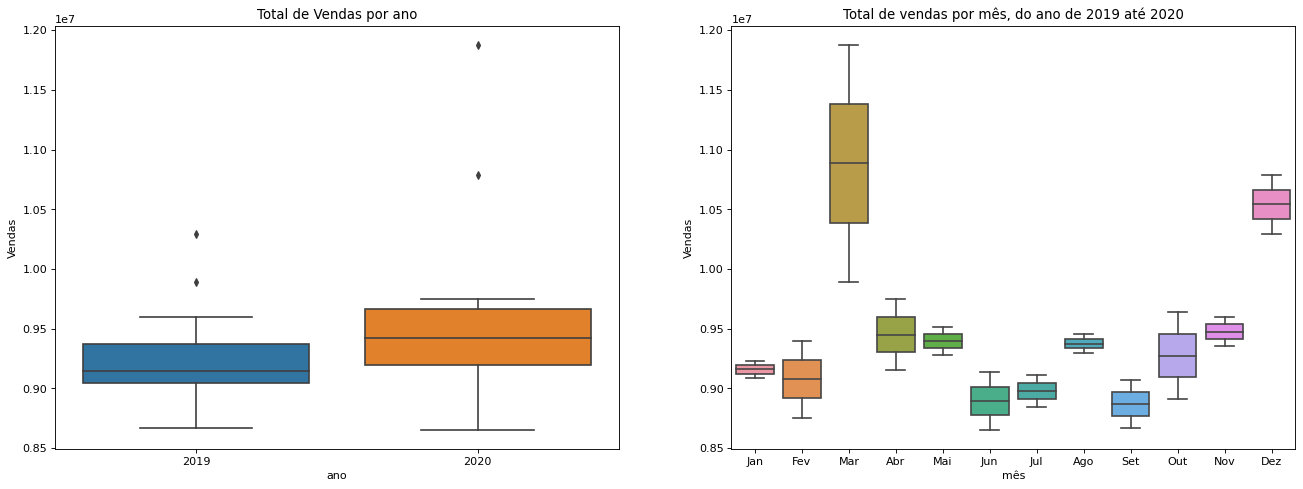

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='ano', y='Vendas', data=vendas_mensal, ax=ax1)
sns.boxplot(x='mês', y='Vendas', data=vendas_mensal, ax=ax2)
ax1.set_title('Total de Vendas por ano')
ax2.set_title('Total de vendas por mês, do ano de 2019 até 2020')
plt.show()


* ### 2.3 Análise de Outliers

In [14]:
outlier = px.box(dados, y="Vendas")
outlier.update_layout(title={
    'text' : 'Outliers'})
print(outlier.show())

None


#### Identificando Outliers com Z-Score

O Z-Score nos da a idéai do quanto um determidado ponto está afastado  da média dos dados.
Mede quantos desvios padrões abaixo ou acima da média dos dados estão. È dado por:

$$z= \frac{x - \mu}{\sigma}$$

Quanto mais longo o Z-score de uma observação está de zero, mais incomum ele é. Um valor de corte padrão para encontrar outliers são escores Z de +/-3 ou mais longe de zero. 

In [15]:
outliers=[]


def find_outliers(data_set):
    
    corte_dp = 3
    media = np.mean(data_set)
    dp = np.std(data_set)
    
    for dado in data_set:
        
        z_score = (dado-media)/dp
        if np.abs(z_score) >= corte_dp:
            outliers.append(dado)
            
            
    return outliers
    

outliers = find_outliers(dados.Vendas)

outliers = pd.DataFrame(outliers)
outliers = outliers.rename(columns = {0:'Vendas'})
outliers 

,Vendas
0,0.01
1,0.01
2,0.01
3,0.01
4,0.01
5,0.01
6,0.01
7,548154.92
8,0.01
9,0.01


Lembrando que as vendas iguais 0.01 são referentes aos períodos adicionados a base de dados, períodos em que a loja não abre

In [16]:
## Considera todos os dados do conjunto de dados

dados_outliers = pd.merge(dados, outliers, how = "left", on= ["Vendas"])
dados_outliers = dados_outliers.drop_duplicates()

* ### 2.4 Decomposição da série em Tendência e Sazonalidade

In [17]:
decomposicao = dados
decomposicao = decomposicao.groupby(by=["Data"])["Vendas"].sum().reset_index()
decomposicao.set_index('Data', inplace=True)


decomposicao_treino = dados[dados["Data"] < '2020-10-01']
decomposicao_treino = decomposicao_treino.groupby(by=["Data"])["Vendas"].sum().reset_index()
decomposicao_treino.set_index('Data', inplace=True)

decomposicao_teste = dados[dados["Data"] >= '2020-10-01']
decomposicao_teste = decomposicao_teste.groupby(by=["Data"])["Vendas"].sum().reset_index()
decomposicao_teste.set_index('Data', inplace=True)

In [18]:
decomposicao_teste

,Vendas
Data,
2020-10-01,316534.80
2020-10-02,368396.22
2020-10-03,437523.35
2020-10-04,349542.88
2020-10-05,261220.32
2020-10-06,291855.50
2020-10-07,302753.93
2020-10-08,261321.33
2020-10-09,308253.01


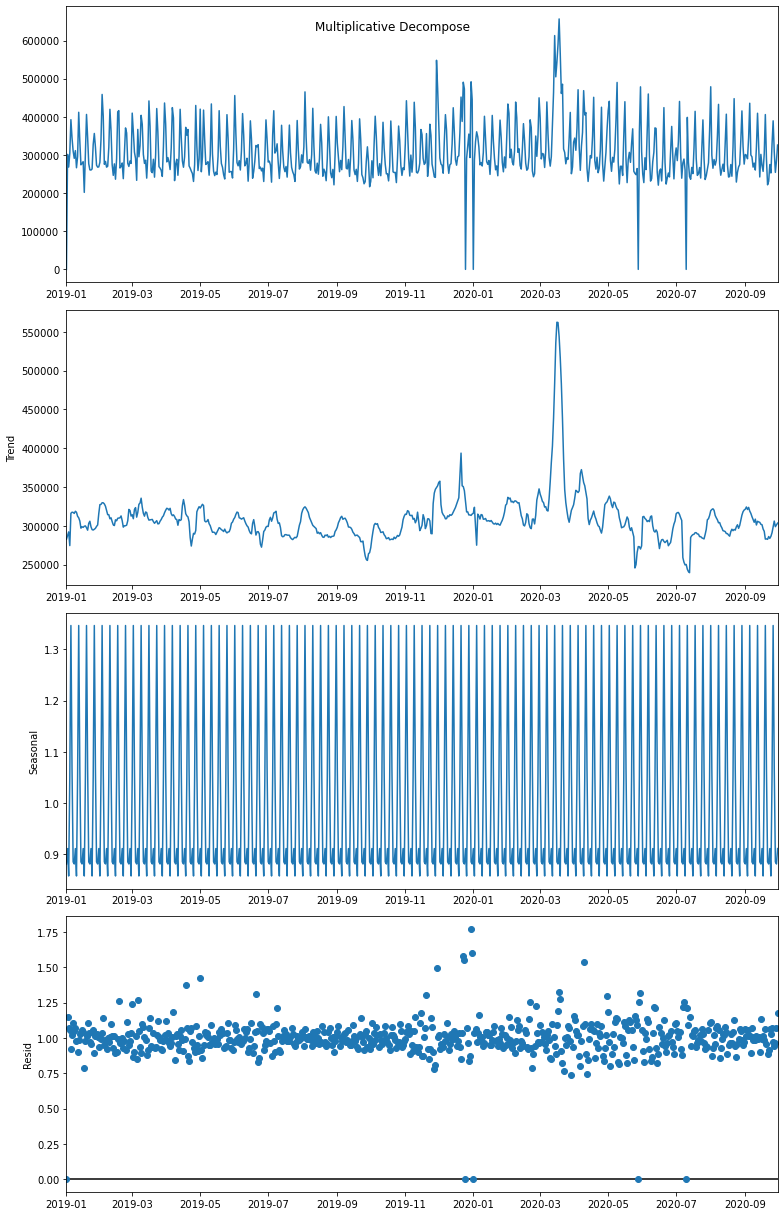

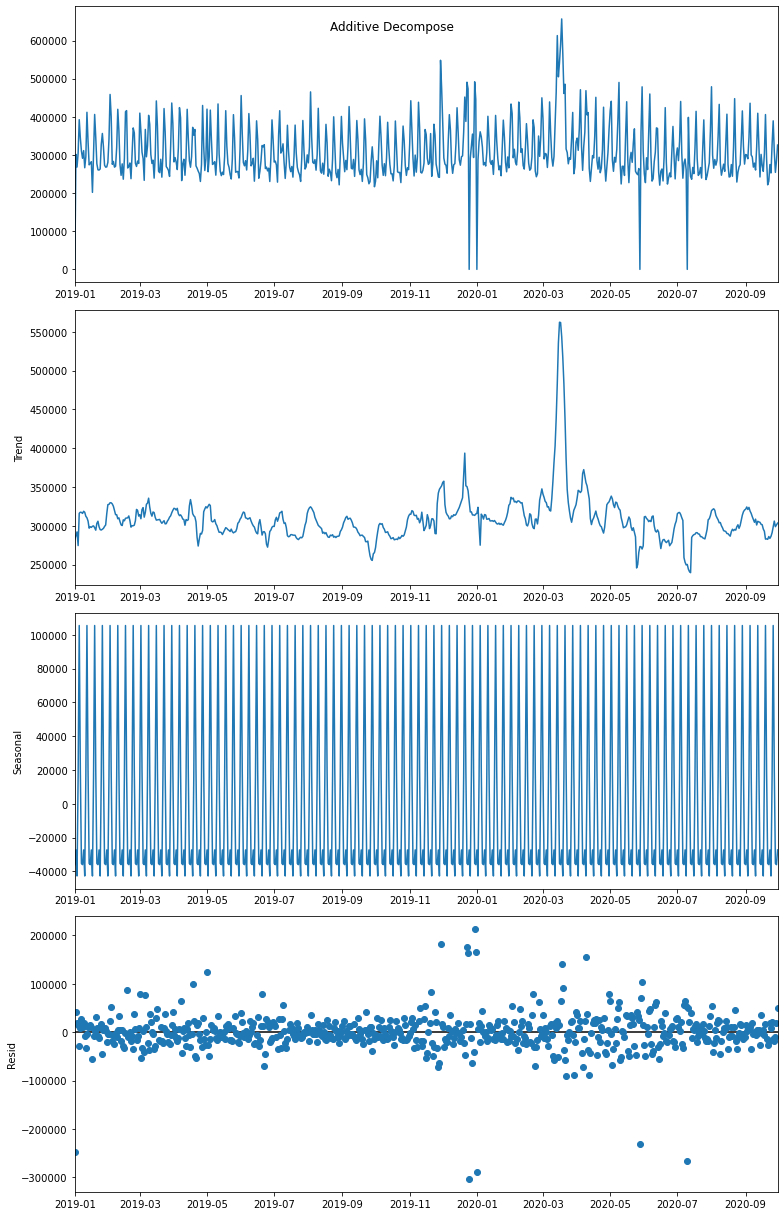

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = (11, 17)

# Multiplicative Decomposition 
result_mul = seasonal_decompose(decomposicao_treino, model='multiplicative', extrapolate_trend='freq',freq=7)
result_mul.plot().suptitle('Multiplicative Decompose');

# Additive Decomposition
result_add = seasonal_decompose(decomposicao_treino, model='additive', extrapolate_trend='freq', freq=7)
result_add.plot().suptitle('Additive Decompose');


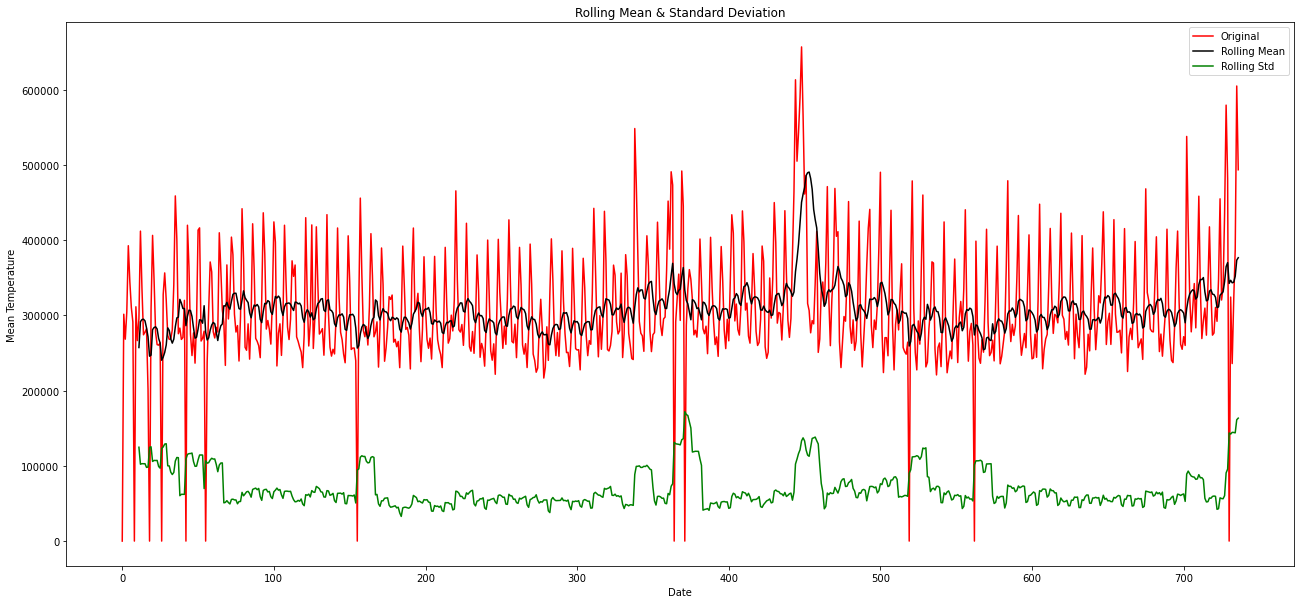

In [20]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
check_mean_std(dados.Vendas)

* ### 2.6 Teste Estacionaridade

A série é considerada estacionária se:

* E(X) = const. para todo t
* Var(X) = const. para todo t
* Cov($Y_{t}, Y_{t+h})$ é função somente de h

Será utilizado os teste de Dickey-Fuller e o teste KPSS para ajudar a estender se a série é estacionáriaou não.

#### Teste de Dickey-Fuller 

$H_{0}$ = Série Não é estacionária

$H_{1}$ = Série é estacionária

Se a estatística do teste > -3,12 não rejeito a hipotese nula
<p>Se a estatística do teste < -3,12 rejeito a hipótese nula

Caso p-valor seja menor que $\alpha$ = 0.05 rejeito $H_{0}$, série é estacionária

Caso p-valor seja maior que $\alpha$ = 0.05 aceito $H_{0}$, ou seja, a série Não é estacionária
                                    
#### Teste de KPSS
                                    
$H_{0}$ = Série é estacionária

$H_{1}$ = Série não é estacionária  
                                    
Caso p-valor seja menor que $\alpha$ = 0.05 rejeito $H_{0}$, série NÃO é estacionária   
Caso p-valor seja maior que $\alpha$ = 0.05 aceito $H_{0}$, ou seja, a série é estacionária                                    

In [21]:
decomposicao =  dados[dados["Data"] < '2020-10-01']
print("Teste de Dickey-Fuller")
adfuller1_3 = adfuller(decomposicao['Vendas'], autolag='AIC')
print(f'ADF Statistic: {adfuller1_3[0]}')
print(f'p-value: {adfuller1_3[1]}')
for key, value in adfuller1_3[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
#print(adfuller1_3)

Teste de Dickey-Fuller
ADF Statistic: -3.607452160364154
p-value: 0.005620146283258618
Critial Values:
   1%, -3.440873084361836
Critial Values:
   5%, -2.866182929627575
Critial Values:
   10%, -2.5692425987220577


In [22]:
result = kpss(decomposicao['Vendas'], regression='c')
print("Teste KPSS")
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
   

Teste KPSS

KPSS Statistic: 0.392966
p-value: 0.080187
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Interpretação

Fazendo o teste de Dickey-Fuller foi obtido p-valor = 0, no teste KPSS foi obtido p-valor 0,08, portanto ao nível de significância de 5% a série é estacionária.

* ### 2.7 Análise FAC e FACP 

#### FAC e FACP da série SEM diferenciação

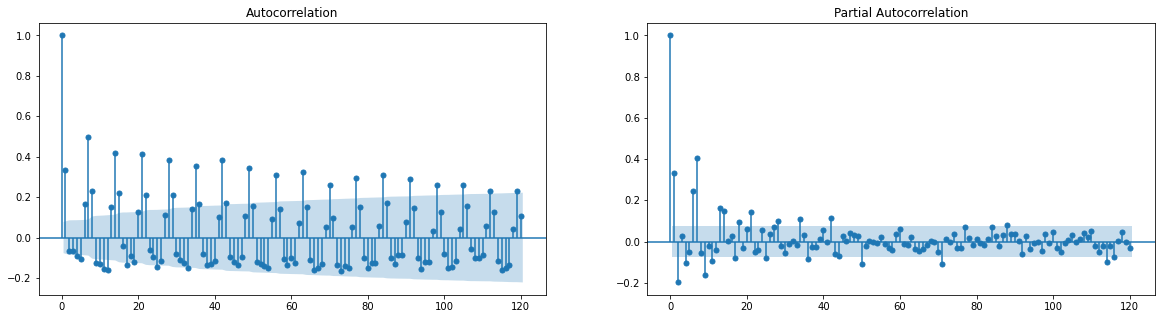

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(decomposicao['Vendas'], lags=120, ax=ax1)  ## Especificando qtd de lags
plot_pacf(decomposicao['Vendas'], lags= 120, ax=ax2) 
plt.show()

#### Fac e FACP da série diferenciada na parte sazonal

Sazonalidade semanal

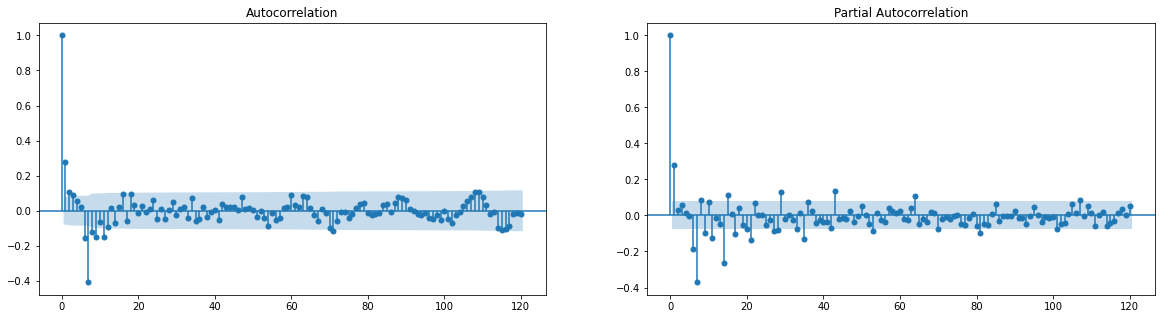

In [24]:
dif = decomposicao['Vendas'].diff(7)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(dif.dropna(), lags=120, ax=ax1)  ## Especificando qtd de lags
plot_pacf(dif.dropna(), lags= 120, ax=ax2) 

plt.show()

<AxesSubplot:>

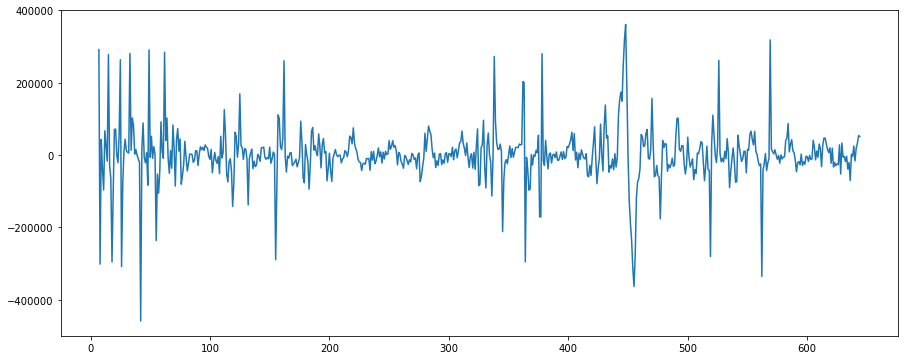

In [25]:
dif.plot(figsize = (15,6))

#### Teste de Ruído Branco

In [26]:
# Vamos agora realizar os testes novamente de ruído branco

#Teste Ljung-Box

import statsmodels.api as sm
sm.stats.acorr_ljungbox(decomposicao['Vendas'], lags=[7], return_df=True)
#p_valor < nível_significancia  => rejeitar a hipotese nula => série não é ruído branco

# Como o valor p-valor foi muito baixo, NÃO HÁ RUIDO BRANCO


,lb_stat,lb_pvalue
7,270.05,0.00


* ### 2.8 Aplicando Transformação log na série 

A transformação log é utilizada para estabilizar a variabilidade da série quando necessário.
Nos dados acima não será aplicada tranaformação


## 3. Separando em treino e teste

In [27]:
treino2 = dados.groupby(by=["Data"])["Vendas"].sum().reset_index().reset_index()

treino2 = treino2[treino2["Data"] < '2020-10-01']
treino2

,index,Data,Vendas
0,0,2019-01-01,0.01
1,1,2019-01-02,301426.63
2,2,2019-01-03,268285.05
3,3,2019-01-04,304634.71
4,4,2019-01-05,392461.88
5,5,2019-01-06,344796.94
6,6,2019-01-07,310172.64
7,7,2019-01-08,291196.43
8,8,2019-01-09,311314.79
9,9,2019-01-10,266396.23


In [28]:
dados.set_index('Data', inplace = True)
teste = dados

In [29]:
## Foram utilizadas modelo SARIMA

apartir19 = teste.Vendas[teste.Vendas.index < '2020-10-01'].reset_index()
apartir19.set_index('Data', inplace=True)

apartir19_teste = teste.Vendas[teste.Vendas.index >=  '2020-10-01'].reset_index()
apartir19_teste.set_index('Data', inplace=True)

t_treino_apartir19 = teste.Vendas[teste.Vendas.index <'2020-10-01'].index.values
t_teste_apartir19 = teste.Vendas[teste.Vendas.index >= '2020-10-01'].index.values
X_treino_apartir19 = teste.Vendas[teste.Vendas.index <'2020-10-01'].values
X_teste_apartir19 = teste.Vendas[teste.Vendas.index >= '2020-10-01'].values

In [30]:
teste.columns

Index(['UnidadeNãoAbre', 'dia', 'mês', 'ano', 'Semana_Mês', 'feriados',
       'pagamento', 'Vale', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
       'sexta', 'sabado', 'Primeira_SemMes', 'Segunda_SemMes',
       'Terceira_SemMes', 'Quarta_SemMes', 'Quinta_SemMes', 'Vendas'],
      dtype='object')

In [31]:
exog = teste.drop(['dia', 'mês', 'ano', 'Semana_Mês','segunda','Quinta_SemMes', 'Vendas'],axis=1)
treino_exog = exog[exog.index < '2020-10-01']
teste_exog = exog[exog.index >= '2020-10-01']

### Função Correlação Cruzada

In [32]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737 entries, 2019-01-01 to 2020-12-31
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnidadeNãoAbre   737 non-null    float64
 1   dia              737 non-null    int64  
 2   mês              737 non-null    int64  
 3   ano              737 non-null    int64  
 4   Semana_Mês       737 non-null    int64  
 5   feriados         737 non-null    int64  
 6   pagamento        737 non-null    int64  
 7   Vale             737 non-null    int64  
 8   domingo          737 non-null    int64  
 9   segunda          737 non-null    int64  
 10  terça            737 non-null    int64  
 11  quarta           737 non-null    int64  
 12  quinta           737 non-null    int64  
 13  sexta            737 non-null    int64  
 14  sabado           737 non-null    int64  
 15  Primeira_SemMes  737 non-null    int64  
 16  Segunda_SemMes   737 non-null    int64  
 1

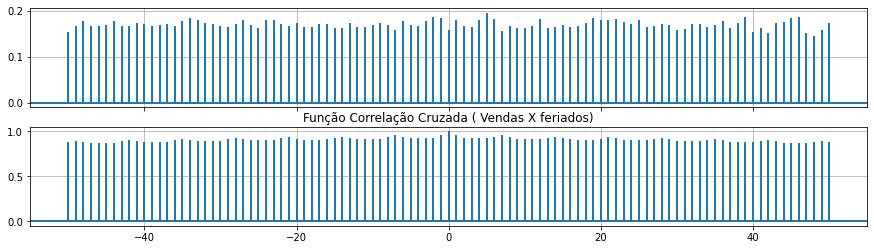

In [33]:
x=teste.Vendas
y=teste.feriados
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(15,4), sharex=True)
plt.title('Função Correlação Cruzada ( Vendas X feriados)')
ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)

ax2.acorr(x, usevlines=True, normed=True, maxlags=50, lw=2)
ax2.grid(True)

plt.show()

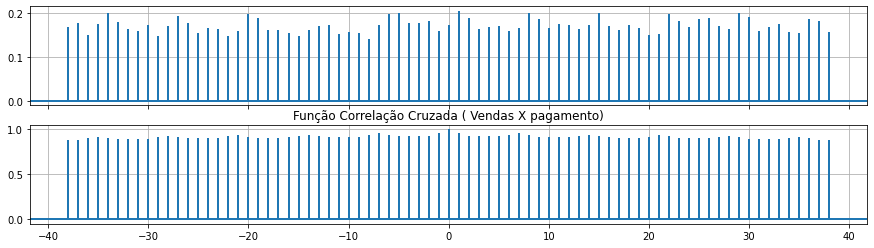

In [34]:
x=teste.Vendas
y=teste.pagamento
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(15,4), sharex=True)
plt.title('Função Correlação Cruzada ( Vendas X pagamento)')
ax1.xcorr(x, y, usevlines=True, maxlags=38, normed=True, lw=2)
ax1.grid(True)

ax2.acorr(x, usevlines=True, normed=True, maxlags=38, lw=2)
ax2.grid(True)

plt.show()

## 4 Modelagem

* #### 4.1 Modelos Exponenciais
* #### 4.2 Modelo SARIMA e SARIMAX


* ### 4.1 Modelos Exponenciais

#### 4.* Método exponencial para tendência e sazonalidade - lag = 7

In [35]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [36]:
decomposicao = decomposicao.Vendas

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



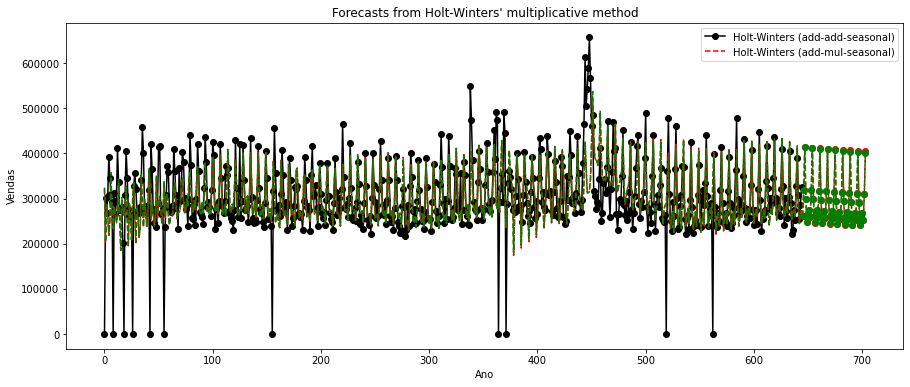

Vendas por Ano - métodos Holt-Winters sazonalidade aditiva vs multiplicativa.


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.04,0.04,0.04,0.04
$\beta$,0.00,0.00,0.00,0.00
$\phi$,NaN,NaN,0.99,0.99
$\gamma$,0.17,0.17,0.17,0.17
$l_0$,56782.39,56782.39,56782.39,56782.39
$b_0$,-28.91,-28.91,-28.91,-28.91
SSE,2572138005587.13,2585879172097.11,2566055040165.10,2582979005621.60


In [37]:
## Comparação de modelos Holt Winters com diferenciação de sazonalidade aditivo e multiplicativo, com Damping e sem Damping
fit1 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = decomposicao.plot(figsize=(15,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Vendas")
ax.set_xlabel("Ano")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(59).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(59).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

# The plot shows the results and forecast for fit1 and fit2. The table allows us to compare the results and parameterizations.
plt.show()
print("Vendas por Ano - métodos Holt-Winters sazonalidade aditiva vs multiplicativa.")

results

<p> Onde $\alpha$ é o parâmetro de suavização para o nível.
<p> Onde $\beta$ é o prâmetro de suavização para tendência.
<p> Onde $\gamma$ é o prâmetro de suavização para sazonalidade.

In [38]:
fit1 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(decomposicao, seasonal_periods=7, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()

fcast1_htw = fit1.forecast(12).rename("Holt Winters Multiplicativo")
print(fit1.summary())  

fcast2_htw = fit2.forecast(12).rename("Holt Winters Multiplicativo")
print(fit2.summary())  

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Vendas   No. Observations:                  645
Model:             ExponentialSmoothing   SSE                  2572138005587.127
Optimized:                         True   AIC                          14280.698
Trend:                         Additive   BIC                          14329.860
Seasonal:                      Additive   AICC                         14281.275
Seasonal Periods:                     7   Date:                 Tue, 08 Mar 2022
Box-Cox:                           True   Time:                         23:32:26
Box-Cox Coeff.:                 0.86214                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0403571                alpha                 True
smoothing_trend          

C:\Python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



#### Acurácia Modelos Alisamento Exponencial

In [39]:
y_true = decomposicao
y_pred_fit1 = fit1.fittedvalues
r2_fit1   = r2_score(y_true, y_pred_fit1)
mse_fit1  = mean_squared_error(y_true, y_pred_fit1)
rmse_fit1 = sqrt(mean_squared_error(y_true, y_pred_fit1))
mae_fit1  = mean_absolute_error(y_true, y_pred_fit1)
mape_fit1 = mean_absolute_percentage_error(y_true, y_pred_fit1)

print('fit1- lag7')
print('R2:   %.3f' % r2_fit1)
print('MSE:  %.3f' % mse_fit1)
print('RMSE: %.3f' % rmse_fit1)
print('MAE:  %.3f' % mae_fit1)
print('MAPE: %.3f' % mape_fit1)
print("*****************************")

y_true = decomposicao
y_pred_fit2 = fit2.fittedvalues
r2_fit2   = r2_score(y_true, y_pred_fit2)
mse_fit2  = mean_squared_error(y_true, y_pred_fit2)
rmse_fit2 = sqrt(mean_squared_error(y_true, y_pred_fit2))
mae_fit2 = mean_absolute_error(y_true, y_pred_fit2)
mape_fit2 = mean_absolute_percentage_error(y_true, y_pred_fit2)

print('fit2- lag7')
print('R2:   %.3f' % r2_fit2)
print('MSE:  %.3f' % mse_fit2)
print('RMSE: %.3f' % rmse_fit2)
print('MAE:  %.3f' % mae_fit2)
print('MAPE: %.3f' % mape_fit2)
print("*****************************")

y_true = decomposicao
y_pred_fit3= fit3.fittedvalues
r2_fit3   = r2_score(y_true, y_pred_fit3)
mse_fit3  = mean_squared_error(y_true, y_pred_fit3)
rmse_fit3 = sqrt(mean_squared_error(y_true, y_pred_fit3))
mae_fit3  = mean_absolute_error(y_true, y_pred_fit3)
mape_fit3 = mean_absolute_percentage_error(y_true, y_pred_fit3)

print('fit3- lag7')
print('R2:   %.3f' % r2_fit3)
print('MSE:  %.3f' % mse_fit3)
print('RMSE: %.3f' % rmse_fit3)
print('MAE:  %.3f' % mae_fit3)
print('MAPE: %.3f' % mape_fit3)
print("*****************************")

y_true = decomposicao
y_pred_fit4 = fit4.fittedvalues
r2_fit4   = r2_score(y_true, y_pred_fit4)
mse_fit4  = mean_squared_error(y_true, y_pred_fit4)
rmse_fit4 = sqrt(mean_squared_error(y_true, y_pred_fit4))
mae_fit4 = mean_absolute_error(y_true, y_pred_fit4)
mape_fit4 = mean_absolute_percentage_error(y_true, y_pred_fit4)

print('fit4- lag7')
print('R2:   %.3f' % r2_fit4)
print('MSE:  %.3f' % mse_fit4)
print('RMSE: %.3f' % rmse_fit4)
print('MAE:  %.3f' % mae_fit4)
print('MAPE: %.3f' % mape_fit4)


fit1- lag7
R2:   0.336
MSE:  3987810861.375
RMSE: 63149.116
MAE:  36941.945
MAPE: 502266.278
*****************************
fit2- lag7
R2:   0.332
MSE:  4009114995.499
RMSE: 63317.573
MAE:  36979.515
MAPE: 505073.824
*****************************
fit3- lag7
R2:   0.337
MSE:  3978379907.233
RMSE: 63074.400
MAE:  36968.545
MAPE: 504377.287
*****************************
fit4- lag7
R2:   0.333
MSE:  4004618613.367
RMSE: 63282.056
MAE:  37013.870
MAPE: 507347.543


In [40]:
#Teste Ljung-Box
sm.stats.acorr_ljungbox(decomposicao, lags=[7], return_df=True)

print(sm.stats.acorr_ljungbox(decomposicao, lags=[7], return_df=True))
print('Conclusão: NÃO É RUIDO BRANCO')

   lb_stat  lb_pvalue
7   270.05       0.00
Conclusão: NÃO É RUIDO BRANCO


* ### 4.2 Modelo SARIMA

   #### 4.2 3. Escolha modelo pelo AutoArima, usando critério AIC

In [41]:
arima_model = auto_arima(apartir19,
                         start_p=0, d=0, start_q=0, 
                         max_p=8, max_q=8, 
                         start_P=0, D=1, start_Q=0, 
                         max_P=8, max_Q=8, 
                         m=7, seasonal=True, 
                         trace=True, 
                         error_action='ignore',
                         supress_warnings=True,stepwise = True)

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16171.376, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=16010.597, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=15916.536, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=16169.427, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=16119.391, Time=0.12 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=15909.913, Time=0.32 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=16010.845, Time=0.13 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=15911.899, Time=0.74 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=15911.897, Time=0.97 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=15909.908, Time=0.40 sec
 ARIMA(0,0,1)(0,1,3)[7] intercept   : AIC=15911.908, Time=0.72 sec
 ARIMA(0,0,1)(1,1,3)[7] intercept   : AIC=15914.085, Time=0.77 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=15987.835, Time=0.29 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=15900.439, Time=0.66 sec
 ARIMA(1,0,1)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  645
Model:             SARIMAX(2, 0, 3)x(0, 1, [1, 2], 7)   Log Likelihood               -7922.324
Date:                                Tue, 08 Mar 2022   AIC                          15860.648
Time:                                        23:34:10   BIC                          15896.315
Sample:                                             0   HQIC                         15874.494
                                                - 645                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0032      0.022     -0.145      0.885      -0.046       0.040
ar.L2          0.9737      0.020     48.356      0.000       0.934       1.013
ma.L1          0.3624      0.035     10.382      0.000       0.294       0.431
ma.L2         -0.8761      0.027    -31.977      0.000      -0.930      -0.822
ma.L3         -0.2769      0.033     -8.485      0.000      -0.341      -0.213
ma.S.L7       -0.7265      0.030    -23.831      0.000      -0.786      -0.667
ma.S.L14      -0.1609      0.035     -4.568      0.000      -0.230      -0.092
sigma2      4.101e+09   2.64e-12   1.55e+21      0.000     4.1e+09     4.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              3439.93
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+37. Standard errors may be unstable.
"""

In [42]:
arima_model = auto_arima(apartir19, start_p =0, d=0, start_q=0,
                            max_p=8, max_d=0, max_q=8, start_P=0,
                            D=1, start_Q=0, m=7, max_P=8, max_D=1,
                            max_Q=8, seasonal=True, error_action='warn', supress_warnings=True, trace= True, stepwise=False,
                            randow_state=20, n_fits=15)

arima_model.summary()

 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16171.376, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=15992.182, Time=0.14 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=15987.835, Time=0.28 sec
 ARIMA(0,0,0)(0,1,3)[7] intercept   : AIC=15989.818, Time=0.58 sec
 ARIMA(0,0,0)(0,1,4)[7] intercept   : AIC=15991.589, Time=0.75 sec
 ARIMA(0,0,0)(0,1,5)[7] intercept   : AIC=15991.388, Time=1.69 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=16069.615, Time=0.20 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=15987.905, Time=0.18 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=15989.835, Time=0.59 sec
 ARIMA(0,0,0)(1,1,3)[7] intercept   : AIC=15992.123, Time=0.56 sec
 ARIMA(0,0,0)(1,1,4)[7] intercept   : AIC=15994.029, Time=0.82 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=16022.713, Time=0.62 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=15989.823, Time=0.49 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=15992.183, Time=0.49 sec
 ARIMA(0,0,0)(2,1,3)[7] intercept   : AIC=15992.464, Time=1.81

 ARIMA(4,0,0)(1,1,0)[7] intercept   : AIC=16003.032, Time=0.28 sec
 ARIMA(4,0,1)(0,1,0)[7] intercept   : AIC=16121.468, Time=0.19 sec
 ARIMA(5,0,0)(0,1,0)[7] intercept   : AIC=16121.267, Time=0.19 sec

Best model:  ARIMA(1,0,3)(0,1,1)[7] intercept
Total fit time: 76.542 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  645
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -7932.605
Date:                             Tue, 08 Mar 2022   AIC                          15879.210
Time:                                     23:35:27   BIC                          15910.418
Sample:                                          0   HQIC                         15891.325
                                             - 645                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -167.3440    230.780     -0.725      0.468    -619.664     284.976
ar.L1          0.8634      0.061     14.191      0.000       0.744       0.983
ma.L1         -0.5232      0.063     -8.321      0.000      -0.646      -0.400
ma.L2         -0.1966      0.045     -4.387      0.000      -0.284      -0.109
ma.L3          0.0594      0.037      1.611      0.107      -0.013       0.132
ma.S.L7       -0.8131      0.025    -32.825      0.000      -0.862      -0.765
sigma2      4.339e+09   8.02e-05   5.41e+13      0.000    4.34e+09    4.34e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              3362.43
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.41e+28. Standard errors may be unstable.
"""

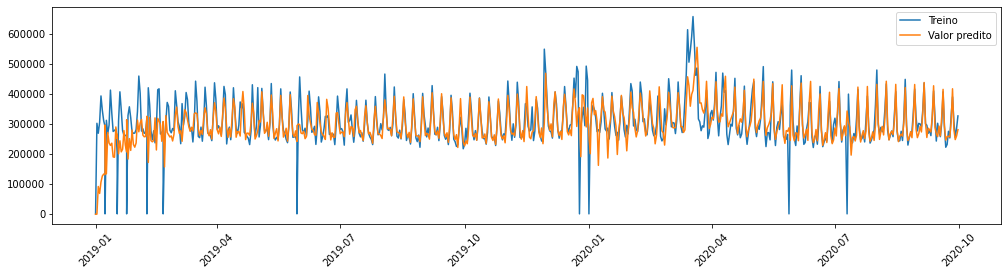

In [43]:
## Base treino

plt.subplots(figsize=(17,4), sharex=True)

yhat = arima_model.predict_in_sample()
apartir19['yhat'] = yhat    
plt.plot(apartir19.Vendas,label='Treino')
plt.plot(apartir19.yhat, label='Valor predito')
plt.xticks(rotation=45)
plt.legend()

In [44]:
# 3. AVALIAÇÃO
# Accuracy metrics base treino

from sklearn.metrics import r2_score

def forecast_accuracy(forecast, actual):
    print("Métricas Acurácia Base Treino")
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    r2 = r2_score(forecast, actual)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'R2':r2})

forecast_accuracy(apartir19.yhat,apartir19.Vendas)

Métricas Acurácia Base Treino


{'mape': 469684.41213884484,
 'me': -7739.455747298054,
 'mae': 37154.57010906177,
 'mpe': 469304.465293184,
 'rmse': 64891.09365242071,
 'corr': 0.5925087543258811,
 'R2': -0.09942110344862898}

In [45]:
################################
# 4. VERIFICAÇÃO
# Avalia a qualidade do ajuste 
# Aplicando teste do ruido branco do resíduo
sm.stats.acorr_ljungbox(arima_model.resid(), lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,22.63,0.01


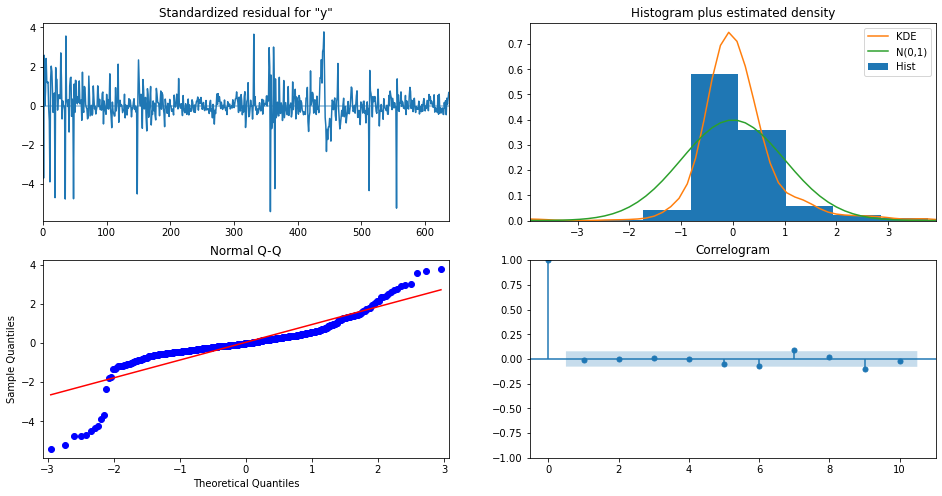

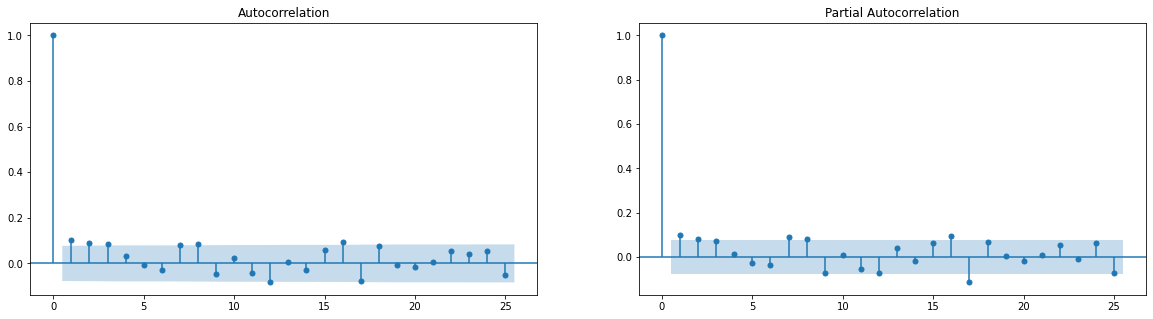

,lb_stat,lb_pvalue
7,22.64,0.00


In [56]:
## Ajuste do modelo

arima_modell = SARIMAX(X_treino_apartir19, order=(1,0,3), seasonal_order = (0,1,1,7)).fit()

#fig=arima_modell.plot_diagnostics()

arima_modell.plot_diagnostics(figsize=(16,8))
plt.show()

## Adicionado pela Aline

import statsmodels.api as sm
from pandas import DataFrame

residuo_modelo = DataFrame(arima_modell.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
## Plot da FAC dos resíduos
plot_acf(residuo_modelo,lags=25, ax=ax1)


## Plot da FACp dos resíduos
plot_pacf(residuo_modelo, lags=25, ax=ax2)
plt.show()

#print('Teste de Box-Ljung')
sm.stats.acorr_ljungbox(arima_modell.resid, lags=[7], return_df=True)
#Esta função retorna uma estatística de teste e um valor p correspondente. Se o valor p for inferior a um nível de significância (por exemplo, α = 0,05), a evidências para rejeitar a hipótese nula e concluir que os resíduos não são distribuídos independentemente.

#shapiro_test = stats.shapiro(residuo_modelo)
#print("", shapiro_test )



#### Verificando desempenho modelo SARIMA, com parâmetros definidos no auto-arima base teste

In [57]:
################################
# 5. FORECAST
n_periods = 89 #tamanho da base de teste
fitted, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(apartir19_teste.index[0], periods = n_periods, freq='D')
index_of_fc

DatetimeIndex(['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
               '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
               '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01',
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09',
               '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13',
               '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17',
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21',
               '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
      

In [58]:
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

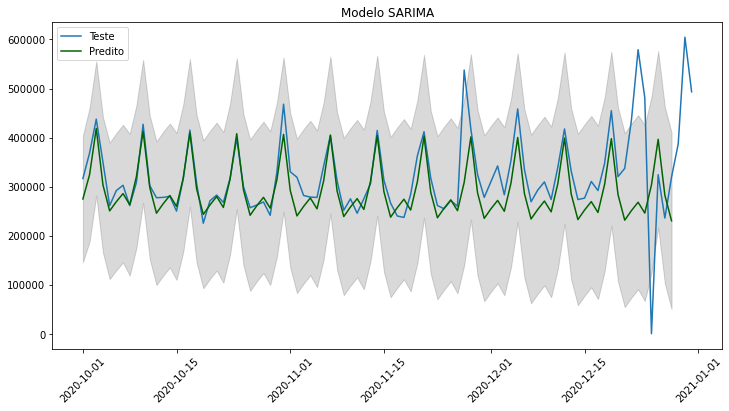

In [59]:
# Plot real x predito - Base teste
plt.figure(figsize=(12,6))
plt.plot(apartir19_teste, label='Teste')
plt.plot(fitted_series, color='darkgreen', label='Predito')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.xticks(rotation=45)


plt.legend()
plt.title("Modelo SARIMA")
plt.show()

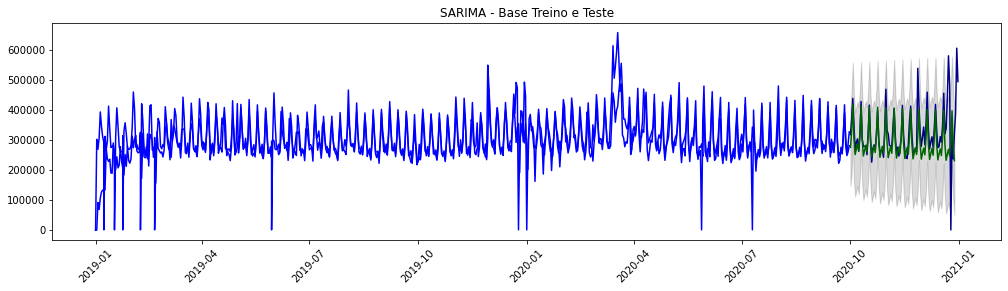

In [60]:
# Plot real x predito - Base train + teste
plt.subplots(figsize=(17,4), sharex=True)
plt.plot(apartir19, color='blue')
plt.plot(apartir19_teste, color='darkblue')
plt.plot(fitted_series, color='darkgreen')    ## Previsão base teste
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xticks(rotation=45)
plt.title("SARIMA - Base Treino e Teste")
plt.show()

### ADIÇÃO VARIÁVEIS EXÓGENAS

   #### 4.2 4. Escolha modelo pelo AutoArima com adição variáveis exogenas

Variáveis exógenas consideradas:

* feriados
* pagamento
* vale
* PrimeiraSemMes
* SegundaSemMes
* TerceiraSemMes
* QuartaSemMes
* UnidadeNãoAbre
* domingo
* terça
* quarta
* quinta
* sexta
* sábado
* domingo

In [51]:
treino_exog

,UnidadeNãoAbre,feriados,pagamento,Vale,domingo,terça,quarta,quinta,sexta,sabado,Primeira_SemMes,Segunda_SemMes,Terceira_SemMes,Quarta_SemMes
Data,,,,,,,,,,,,,,
2019-01-01,1.00,1,0,0,0,1,0,0,0,0,0,0,1,0
2019-01-02,0.00,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-01-03,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0
2019-01-04,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-05,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0
2019-01-06,0.00,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-07,0.00,0,1,0,0,0,0,0,0,0,0,1,0,0
2019-01-08,0.00,0,0,0,0,1,0,0,0,0,0,0,1,0
2019-01-08,1.00,0,0,0,0,1,0,0,0,0,0,0,1,0


In [52]:
modelo_checagem = auto_arima(apartir19['Vendas'],exogenous=treino_exog , start_p =0, d=0, start_q=0,
                            max_p=8, max_d=0, max_q=8, start_P=0,
                            D=1, start_Q=0, m=7, max_P=8, max_D=1,
                            max_Q=8, seasonal=True, error_action='warn', trace= True, stepwise=False)


 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=15781.289, Time=0.15 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=15641.414, Time=0.59 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=15628.368, Time=0.98 sec
 ARIMA(0,0,0)(0,1,3)[7] intercept   : AIC=15630.366, Time=1.49 sec
 ARIMA(0,0,0)(0,1,4)[7] intercept   : AIC=15631.229, Time=2.44 sec
 ARIMA(0,0,0)(0,1,5)[7] intercept   : AIC=15632.796, Time=4.50 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=15701.998, Time=0.96 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=15628.867, Time=0.80 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=15630.368, Time=1.82 sec
 ARIMA(0,0,0)(1,1,3)[7] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(0,0,0)(1,1,4)[7] intercept   : AIC=15633.446, Time=2.53 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=15658.425, Time=2.26 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=15630.696, Time=1.92 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=15630.211, Time=3.10 sec
 ARIMA(0,0,0)(2,1,3)[7] intercept   : AIC=15631.889, Time=6.30 sec
 

 ARIMA(4,0,0)(1,1,0)[7] intercept   : AIC=15410.100, Time=1.06 sec
 ARIMA(4,0,1)(0,1,0)[7] intercept   : AIC=15492.106, Time=1.93 sec
 ARIMA(5,0,0)(0,1,0)[7] intercept   : AIC=15514.967, Time=0.74 sec

Best model:  ARIMA(1,0,3)(0,1,1)[7] intercept
Total fit time: 232.399 seconds


C:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                      SARIMAX Results                                      
Dep. Variable:                              Vendas   No. Observations:                  645
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -7629.713
Date:                             Tue, 08 Mar 2022   AIC                          15299.426
Time:                                     23:39:26   BIC                          15388.593
Sample:                                          0   HQIC                         15334.041
                                             - 645                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
UnidadeNãoAbre  -2.914e+05   1.17e+04    -24.968      0.000   -3.14e+05   -2.69e+05
feriados    

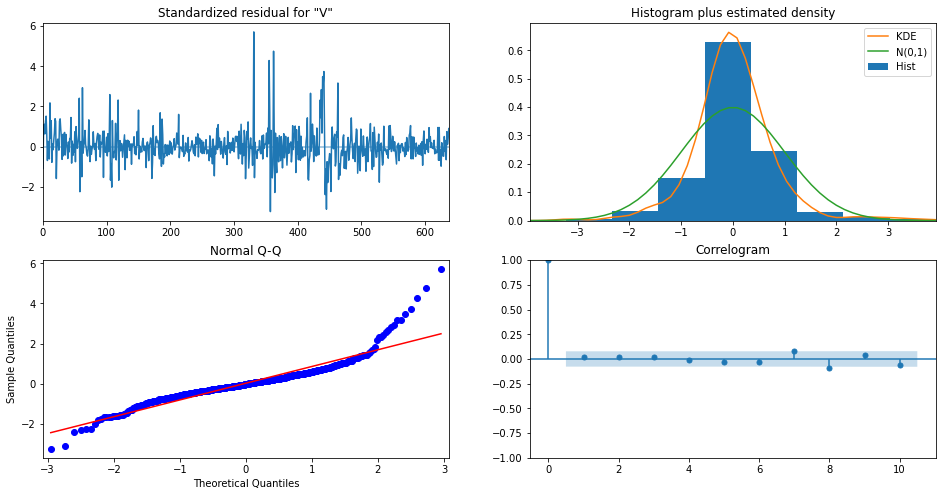

<Figure size 792x1224 with 0 Axes>

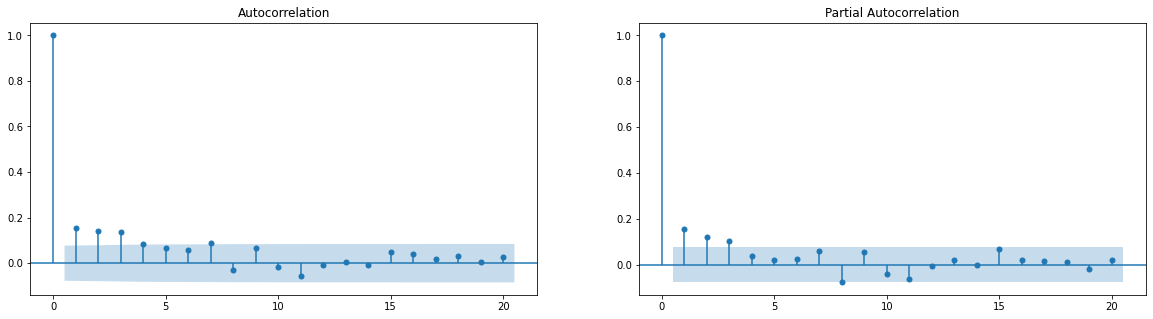

 ShapiroResult(statistic=0.8444644212722778, pvalue=1.2172422548628065e-24)
Teste ljungbox


,lb_stat,lb_pvalue
14,61.76,0.00


In [53]:
## Rodando AutoArima com adição das variáveis exogenas foi obtido que o melhor modelo é: SARIMA (1,0,3)(0,1,1)
modelo_sarima_exog = SARIMAX(endog = apartir19['Vendas'], exog= treino_exog, order=(1,0,3), seasonal_order = (0,1,1,7)).fit()
                
print(modelo_sarima_exog.summary())

modelo_sarima_exog.plot_diagnostics(figsize=(16,8))
plt.show()


import statsmodels.api as sm
from pandas import DataFrame

residuo_modelo_sarima_exog = DataFrame(modelo_sarima_exog.resid)
print(modelo_sarima_exog)

## FAC e FACP residual
plt.figure()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(residuo_modelo_sarima_exog,lags=20, ax = ax1)

plot_pacf(residuo_modelo_sarima_exog, lags=20, ax = ax2)
plt.show()

shapiro_test = stats.shapiro(residuo_modelo_sarima_exog)
print("", shapiro_test )

print("Teste ljungbox")
sm.stats.acorr_ljungbox(modelo_sarima_exog.resid, lags=[14], return_df=True)



Métrica Acurácia Base treino

In [54]:
y_hat_train = modelo_sarima_exog.forecast(steps=treino_exog.shape[0],exog=treino_exog)
len(y_hat_train)


y_true = apartir19['Vendas']
y_pred = y_hat_train
r2   = r2_score(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('R2:   %.3f' % r2)
print('MSE:  %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('MAE:  %.3f' % mae)
print('MAPE: %.3f' % mape)

R2:   0.509
MSE:  2945877166.686
RMSE: 54275.935
MAE:  38157.437
MAPE: 55639.400


C:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

